In [31]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set_style("whitegrid")
pd.options.display.max_columns = 200

In [32]:
data = pd.read_csv("../media/Clean_Shoe_Data.csv")
print("Shape:", data.shape)
print("Columns:", list(data.columns))
display(data.head())

Shape: (99956, 8)
Columns: ['Order Date', 'Brand', 'Sneaker Name', 'Sale Price', 'Retail Price', 'Release Date', 'Shoe Size', 'Buyer Region']


,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,2017-09-01,Yeezy,Adidas Yeezy Boost 350 Low V2 Beluga,1097,220,2016-09-24,11.0,California
1,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Copper,685,220,2016-11-23,11.0,California
2,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Green,690,220,2016-11-23,11.0,California
3,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Red,1075,220,2016-11-23,11.5,Kentucky
4,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Red 2017,828,220,2017-02-11,11.0,Rhode Island


In [41]:
target_col = "Sale Price"
retail_col = "Retail Price"
brand_col = "Brand"
release_col = "Release Date"
size_col = "Shoe Size"
region_col = "Buyer Region"

In [42]:
for col in [target_col, retail_col]:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col].astype(str).str.replace(r'[^0-9.\-]', '', regex=True), errors='coerce')
for dt_col in ["Order Date", "Release Date"]:
    if dt_col in data.columns:
        data[dt_col + "_dt"] = pd.to_datetime(data[dt_col], errors='coerce')
data["release_year"] = data["Release Date_dt"].dt.year
data["order_year"] = data["Order Date_dt"].dt.year

if "Shoe Size" in data.columns:
    data["Shoe Size"] = pd.to_numeric(data["Shoe Size"], errors="coerce")

print("Sale Price: nulls =", data["Sale Price"].isna().sum() if "Sale Price" in data.columns else "no column")
data_ml = data.dropna(subset=[target_col]).copy()  
display(data_ml.describe(include="all").T)

Sale Price: nulls = 0


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Order Date,99956,531,2018-11-16,1388,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Brand,99956,2,Yeezy,72162,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sneaker Name,99956,50,adidas Yeezy Boost 350 V2 Butter,11423,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sale Price,99956.0,NaN,NaN,NaN,446.634719,186.0,275.0,370.0,540.0,4050.0,255.982969
Retail Price,99956.0,NaN,NaN,NaN,208.61359,130.0,220.0,220.0,220.0,250.0,25.20001
Release Date,99956,35,2018-06-30,11423,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Shoe Size,99956.0,NaN,NaN,NaN,9.344181,3.5,8.0,9.5,11.0,17.0,2.329588
Buyer Region,99956,51,California,19349,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Order Date_dt,99956,NaN,NaN,NaN,2018-08-12 21:24:50.623874560,2017-09-01 00:00:00,2018-05-02 00:00:00,2018-09-24 00:00:00,2018-12-15 00:00:00,2019-02-13 00:00:00,NaN
Release Date_dt,99956,NaN,NaN,NaN,2018-02-10 04:24:17.057105408,2015-06-27 00:00:00,2017-09-09 00:00:00,2017-12-16 00:00:00,2018-08-03 00:00:00,2019-02-07 00:00:00,NaN


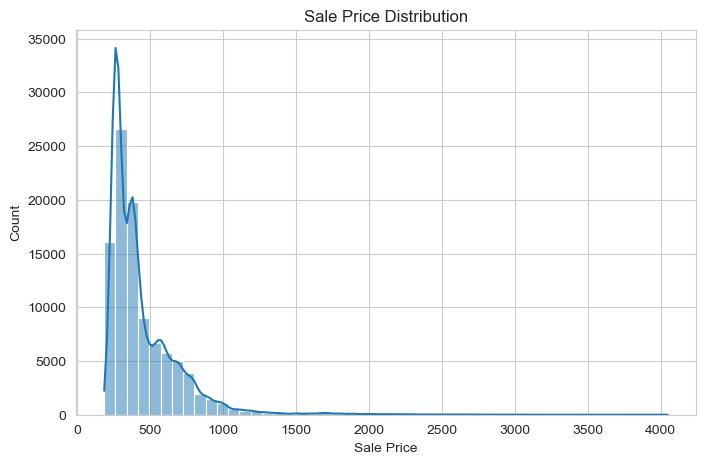

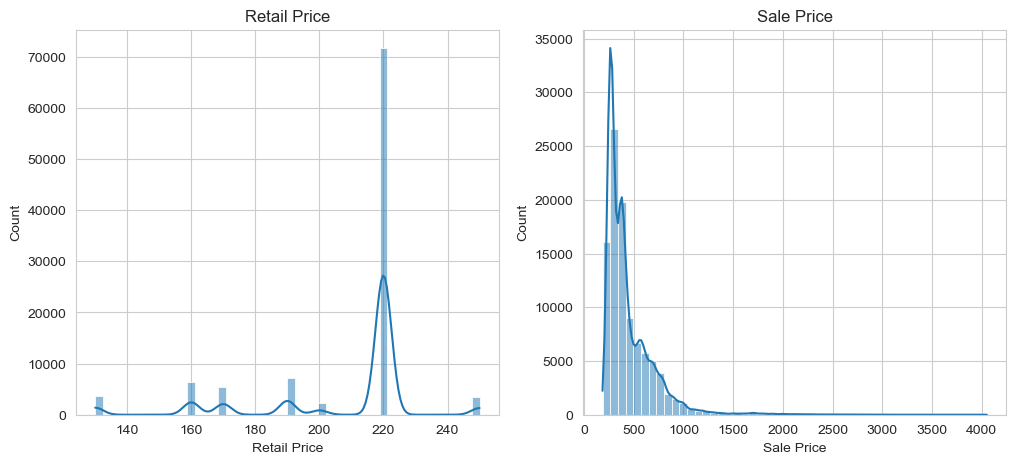

In [35]:
plt.figure(figsize=(8,5))
sns.histplot(data_ml["Sale Price"], bins=50, kde=True)
plt.title("Sale Price Distribution")
plt.xlabel("Sale Price")
plt.show()
fig, axes = plt.subplots(1,2,figsize=(12,5))
sns.histplot(data_ml["Retail Price"].dropna(), bins=50, kde=True, ax=axes[0])
axes[0].set_title("Retail Price")
sns.histplot(data_ml["Sale Price"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Sale Price")
plt.show()

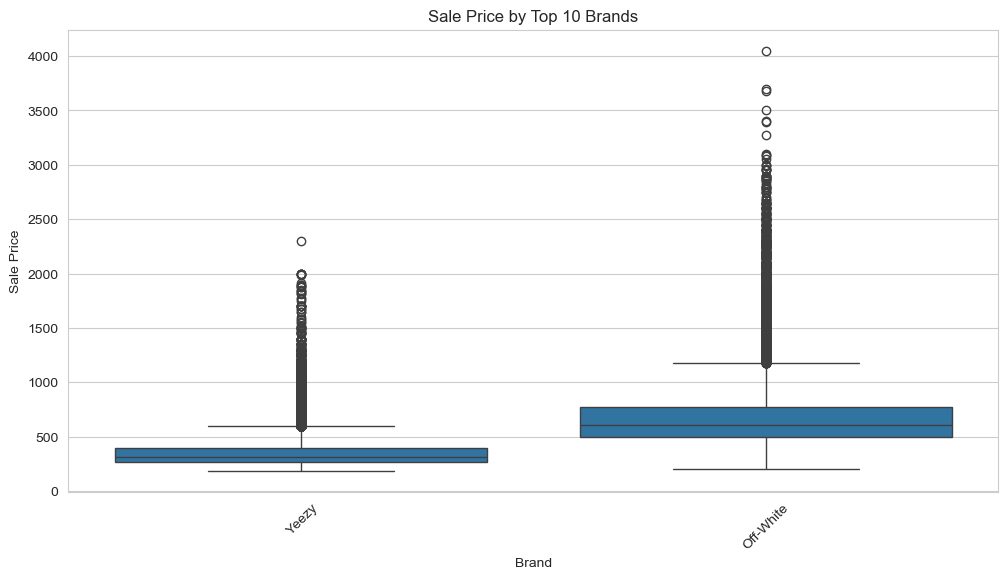

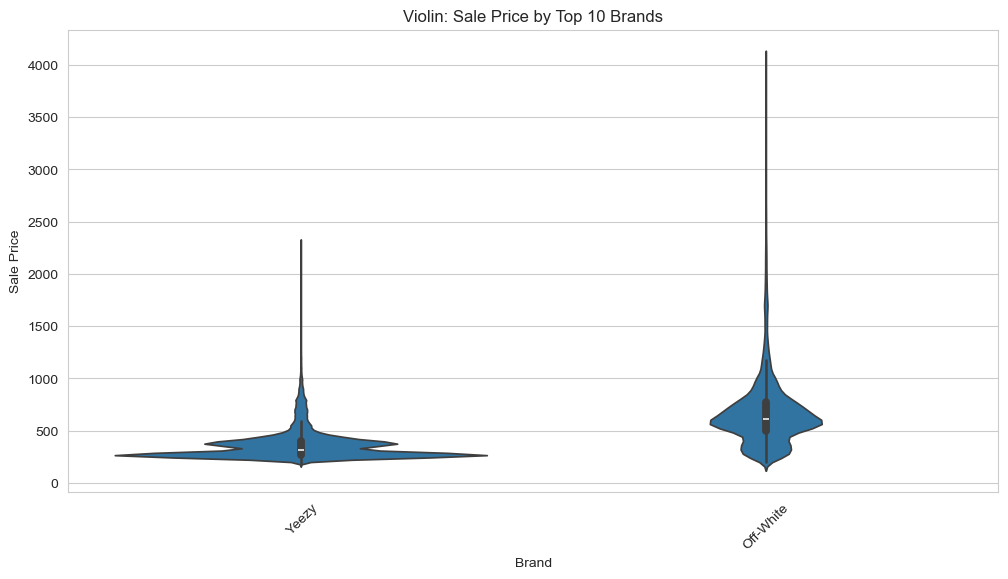

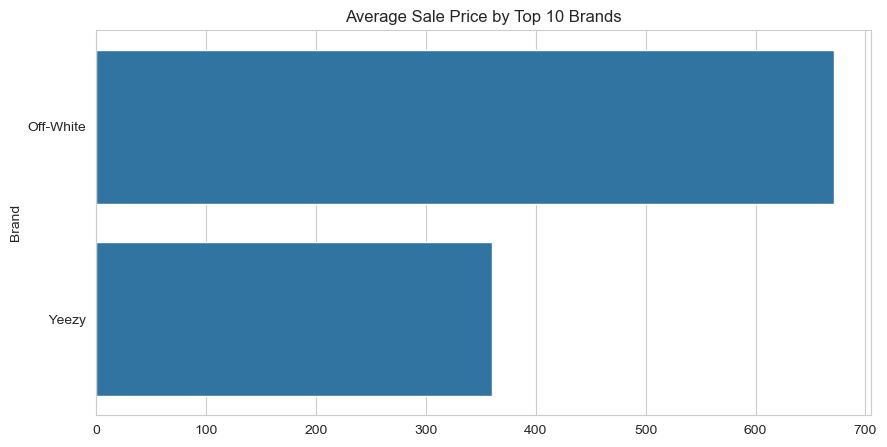

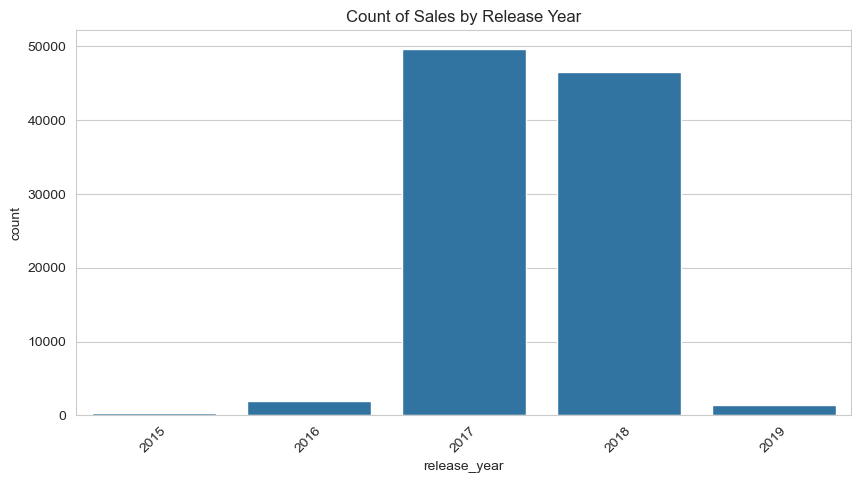

In [36]:
if "Brand" in data_ml.columns:
    top_brands = data_ml["Brand"].value_counts().head(10).index
    plt.figure(figsize=(12,6))
    sns.boxplot(data=data_ml[data_ml["Brand"].isin(top_brands)], x="Brand", y="Sale Price")
    plt.xticks(rotation=45)
    plt.title("Sale Price by Top 10 Brands")
    plt.show()
    plt.figure(figsize=(12,6))
    sns.violinplot(data=data_ml[data_ml["Brand"].isin(top_brands)], x="Brand", y="Sale Price")
    plt.xticks(rotation=45)
    plt.title("Violin: Sale Price by Top 10 Brands")
    plt.show()
if "Brand" in data_ml.columns:
    brand_avg = data_ml.groupby("Brand")["Sale Price"].mean().sort_values(ascending=False).head(10)
    plt.figure(figsize=(10,5))
    sns.barplot(x=brand_avg.values, y=brand_avg.index)
    plt.title("Average Sale Price by Top 10 Brands")
    plt.show()
if "release_year" in data_ml.columns:
    yrs = sorted(data_ml["release_year"].dropna().unique())
    if len(yrs) > 0:
        plt.figure(figsize=(10,5))
        sns.countplot(x="release_year", data=data_ml[data_ml["release_year"].notna()], order=yrs)
        plt.xticks(rotation=45)
        plt.title("Count of Sales by Release Year")
        plt.show()

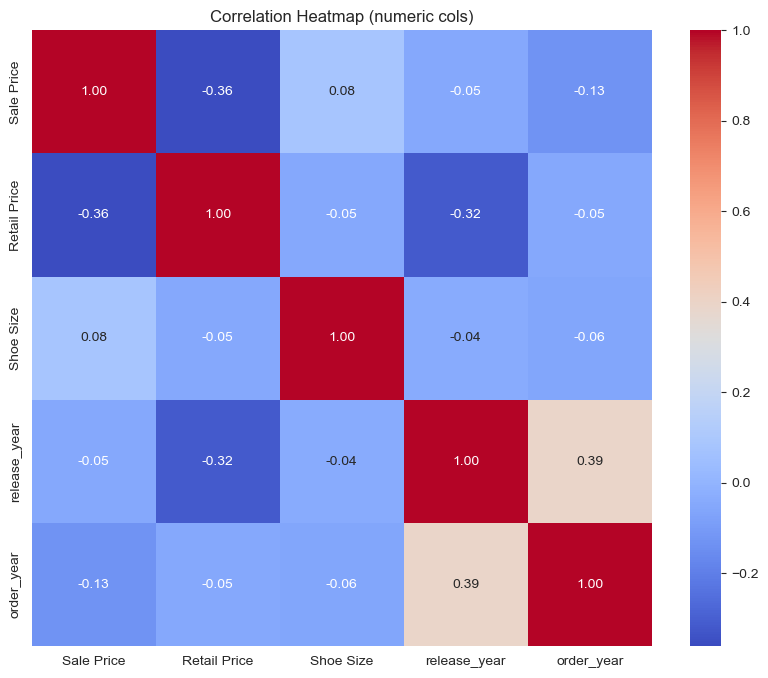

In [37]:
num_df = data_ml.select_dtypes(include=[np.number])
if not num_df.empty:
    plt.figure(figsize=(10,8))
    sns.heatmap(num_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation Heatmap (numeric cols)")
    plt.show()

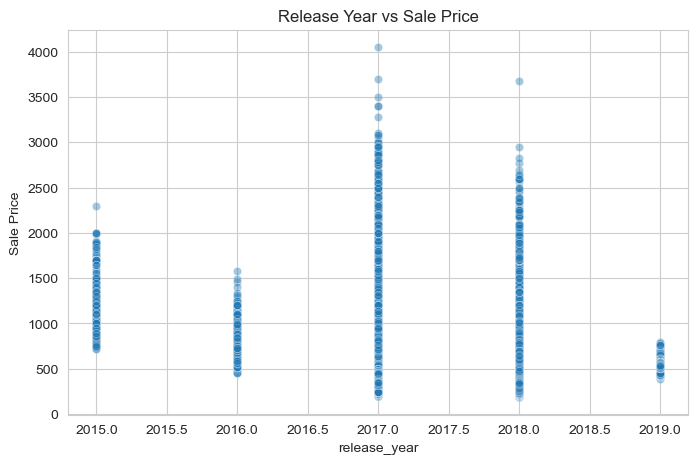

In [38]:
if "release_year" in data_ml.columns:
    plt.figure(figsize=(8,5))
    sns.scatterplot(x="release_year", y="Sale Price", data=data_ml, alpha=0.4)
    plt.title("Release Year vs Sale Price")
    plt.show()

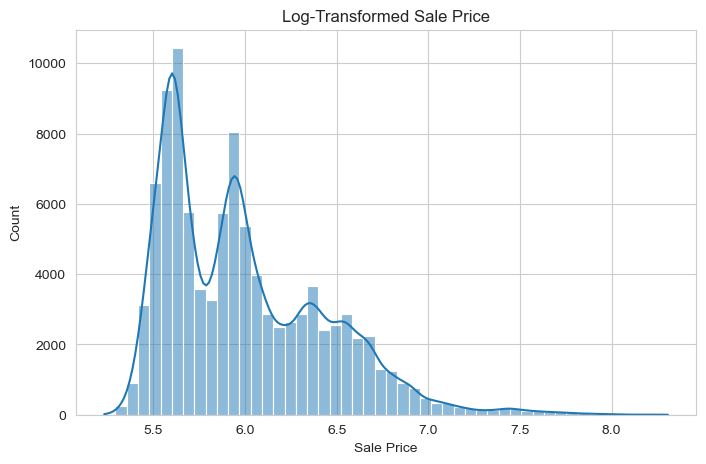

In [39]:
plt.figure(figsize=(8,5))
sns.histplot(np.log1p(data_ml["Sale Price"]), bins=50, kde=True)
plt.title("Log-Transformed Sale Price")
plt.show()

In [40]:
required_features = [f for f in ["Retail Price", "release_year", "Shoe Size", "Brand", "Buyer Region"] if f in data_ml.columns]
print("Features chosen for model:", required_features)
X = data_ml[required_features].copy()
y = data_ml["Sale Price"].copy()

Features chosen for model: ['Retail Price', 'release_year', 'Shoe Size', 'Brand', 'Buyer Region']


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)